## KAN RL

In [1]:
!pip install moviepy~=1.0.3 gymnasium pykan~=0.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 45.9 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=272e473789d572d38c746c81668c4290501413ce2bd99336caa66d1218a03298
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


## Models

100%|██████████| 26421880/26421880 [00:03<00:00, 6801501.70it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 134014.13it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2549318.42it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8609360.84it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

State shape: torch.Size([1, 8, 8])
Label: tensor(3)
Feedback shape: torch.Size([1, 8, 8])


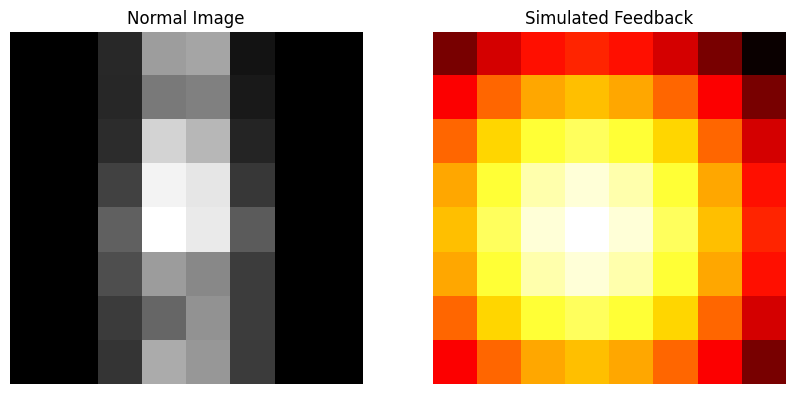

tensor(0.5273) tensor(1.)


In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# https://github.com/Armour/pytorch-nn-practice/blob/master/utils/meanstd.py  for normalization values computation

class BenchmarkEnvironment:
    def __init__(self, dataset_name='MNIST', batch_size=128, image_size=(8, 8), feedback_sigma=5.0):
        self.batch_size = batch_size
        self.image_size = image_size
        self.feedback_sigma = feedback_sigma
        self.num_channels = 1  # Force single channel for all datasets

        if dataset_name == 'MNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            self.dataset = datasets.MNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'FashionMNIST':
            # self.num_channels = 1
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR10':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR10('./data', train=True, download=True, transform=self.transform)

        elif dataset_name == 'CIFAR100':
            # self.num_channels = 3
            self.transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)),
                transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
            ])
            self.dataset = datasets.CIFAR100('./data', train=True, download=True, transform=self.transform)

        else:
            raise ValueError(f"Dataset {dataset_name} is not supported.")

        self.loader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        self.iterator = iter(self.loader)
        self.reset()

    def reset(self):
        try:
            self.current_batch = next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.loader)
            self.current_batch = next(self.iterator)
        self.idx = 0

    def step(self):
        images, labels = self.current_batch
        if self.idx >= len(images):
            self.reset()
            return self.step()
        state = images[self.idx]
        label = labels[self.idx]
        feedback = self.generate_simulated_feedback(state.unsqueeze(0))
        self.idx += 1
        return state, label, feedback

    def generate_simulated_feedback(self, image_tensor):
        image_np = image_tensor.squeeze().numpy()

        # Normalize the image to [0, 1]
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))

        center_of_mass = np.array(np.unravel_index(np.argmax(image_np), image_np.shape[-2:]))

        x, y = np.meshgrid(np.arange(image_np.shape[-1]), np.arange(image_np.shape[-2]))
        gaussian_mask = np.exp(-((x - center_of_mass[1])**2 + (y - center_of_mass[0])**2) / (2 * self.feedback_sigma**2))

        feedback = gaussian_mask / np.max(gaussian_mask)
        return torch.tensor(feedback, dtype=torch.float32).view(1, *feedback.shape)


def plot_images(normal_image, feedback_image):
    # Convert tensors to numpy arrays
    normal_image_np = normal_image.squeeze().numpy()
    feedback_image_np = feedback_image.squeeze().numpy()

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot normal image
    axes[0].imshow(normal_image_np, cmap='gray')
    axes[0].set_title('Normal Image')
    axes[0].axis('off')

    # Plot feedback image
    axes[1].imshow(feedback_image_np, cmap='hot')  # Using 'hot' colormap to visualize feedback
    axes[1].set_title('Simulated Feedback')
    axes[1].axis('off')

    plt.show()

# Example usage:
if __name__ == "__main__":
    env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=128, feedback_sigma=5.0)
    state, label, feedback = env.step()
    print("State shape:", state.shape)
    print("Label:", label)
    print("Feedback shape:", feedback.shape)
    plot_images(state, feedback)
    print(feedback.min(), feedback.max())


In [3]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from torch.optim.lr_scheduler import ExponentialLR

class FSNet(nn.Module):
    def __init__(self, input_shape, num_filters, num_conv_layers=3, hidden_dim=128, distribution=None, tau=1.0):
        super(FSNet, self).__init__()

        self.distribution = distribution
        self.global_step = 0
        self.initial_tau = tau
        self.tau_decay = 0.96  # Exponential decay rate

        layers = []
        in_channels = input_shape[0]
        channels = []

        for i in range(num_conv_layers):
            num_filters *= 2
            channels.append(num_filters)

        for i in range(num_conv_layers):
            # For a convolutional layer to keep the input and output shapes the same: P = (K-1)/2 with S = 1
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU())
            # Each MaxPool2d layer with kernel size 2 and stride 2 will halve the height and width of the feature maps.
            layers.append(nn.MaxPool2d(2, 2))
            in_channels = channels[i]

        layers.append(nn.Flatten())
        self.feature_extractor = nn.Sequential(*layers)

        # Dummy forward pass to determine the output size of the feature extractor
        dummy_input = torch.empty(1, *input_shape)
        n_features = self.feature_extractor(dummy_input).shape[1]
        # print(n_features)

        self.fc1 = nn.Linear(n_features, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(hidden_dim, n_features)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=-1)

        # Storage for probabilities and feedback costs
        self.probs_history = []
        self.feedback_cost_history = []


    def forward(self, x, feedback=None, epoch=0, n_epochs=None):
        x = x.view(-1, 1, input_shape[1], input_shape[2])
        features = self.feature_extractor(x)

        x = self.relu(self.fc1(features))
        probs_logits = self.relu(self.fc2(x))
        probs = self.sigmoid(probs_logits)

        # Apply the simulated feedback as a weight to the feature selection
        if feedback is None:
            feedback = probs # so that mse_loss becomes 0 if no feedback is fed
        else:
            pass

        # Use distribution as weight of the features
        if self.distribution == 'bernoulli':
            mask = torch.distributions.Bernoulli(logits=probs_logits)
            sample_probs = mask.sample()
        if self.distribution == 'gumbel_softmax':
            tau = self.initial_tau * (self.tau_decay ** epoch)
            mask = F.gumbel_softmax(logits=probs_logits, tau=tau, hard=False)
            sample_probs = mask
        if self.distribution == 'gaussian':
            mu = probs_logits  # or some transformation of probs_logits
            sigma = torch.ones_like(mu)  # Standard deviation
            gaussian_dist = torch.distributions.Normal(mu, sigma)
            sample_probs = gaussian_dist.rsample()  # Use rsample for the reparameterization trick
        if self.distribution == 'beta':
            alpha = F.softplus(probs_logits) + 1
            beta = F.softplus(probs_logits) + 1
            beta_dist = torch.distributions.Beta(alpha, beta)
            sample_probs = beta_dist.sample()
        if self.distribution == 'dirichlet':
            concentration = F.softplus(probs_logits) + 1  # Ensuring positive values
            dirichlet_dist = torch.distributions.Dirichlet(concentration)
            sample_probs = dirichlet_dist.sample()
        elif self.distribution == 'multinomial':
            logits = probs_logits  # Logits for the multinomial distribution
            mask = torch.distributions.Multinomial(logits=logits)
            sample_probs = mask.sample()
        elif self.distribution == 'laplace':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            laplace_dist = torch.distributions.Laplace(loc, scale)
            sample_probs = laplace_dist.sample()
        elif self.distribution == 'cauchy':
            loc = probs_logits  # Mean of the logistic distribution
            scale = torch.ones_like(loc)  # Scale parameter
            cauchy_dist = torch.distributions.Cauchy(loc, scale)
            sample_probs = cauchy_dist.sample()
        elif self.distribution == 'uniform':
            low = torch.zeros_like(probs_logits)  # Lower bound
            high = torch.ones_like(probs_logits)  # Upper bound
            uniform_dist = torch.distributions.Uniform(low, high)
            sample_probs = uniform_dist.sample()            

        # print(sample_probs.shape)

        feedback_cost = F.mse_loss(probs, feedback)

        flat_zoom_X = features * sample_probs

        return flat_zoom_X, feedback_cost, probs


# Example usage:
input_shape = (1, 8, 8)  # Change this to the desired input shape
num_conv_layers = 2  # Specify the desired number of convolutional layers
num_filters = 4 # [2,4], [3,8]
model = FSNet(input_shape, num_filters, num_conv_layers, hidden_dim=128, distribution='uniform')
print(model)

# Test with an example input
example_input = torch.randn(*input_shape)

# print(flat_zoom_X, probs)
# print(flat_zoom_X.shape[1])
flat_zoom_X, feedback_cost, probs = model.forward(example_input)
print(flat_zoom_X.shape)

FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
torch.Size([1, 64])


In [4]:
# @title
from collections import deque
import os
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from kan import KAN
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional, Callable, Union

class ReplayBuffer:
    def __init__(self, capacity, observation_dim):
        self.capacity = capacity
        self.observations = torch.zeros(capacity, observation_dim)
        self.actions = torch.zeros(capacity, 1, dtype=torch.int64)
        self.next_observations = torch.zeros(capacity, observation_dim)
        self.rewards = torch.zeros(capacity, 1)
        self.terminations = torch.zeros(capacity, 1, dtype=torch.int)
        self.cursor = 0

    def add(self, observation, action, next_observation, reward, termination):
        index = self.cursor % self.capacity
        self.observations[index] = observation
        self.actions[index] = action
        self.next_observations[index] = next_observation
        self.rewards[index] = reward
        self.terminations[index] = termination
        self.cursor += 1

    def sample(self, batch_size):
        idx = np.random.permutation(np.arange(len(self)))[:batch_size]
        return (
            self.observations[idx],
            self.actions[idx],
            self.next_observations[idx],
            self.rewards[idx],
            self.terminations[idx],
        )

    def __len__(self):
        return min(self.cursor, self.capacity)



def kan_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    lamb=0.0,
    lamb_l1=1.0,
    lamb_entropy=2.0,
    lamb_coef=0.0,
    lamb_coefdiff=0.0,
    small_mag_threshold=1e-16,
    small_reg_factor=1.0,
    feedback_cost=None,
    feature_selection=False,
):
    

    def reg(acts_scale):
        def nonlinear(x, th=small_mag_threshold, factor=small_reg_factor):
            return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

        reg_ = 0.0
        for i in range(len(acts_scale)):
            vec = acts_scale[i].reshape(
                -1,
            )

            p = vec / torch.sum(vec)
            l1 = torch.sum(nonlinear(vec))
            entropy = -torch.sum(p * torch.log2(p + 1e-4))
            reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

        # regularize coefficient to encourage spline to be zero
        for i in range(len(net.act_fun)):
            coeff_l1 = torch.sum(torch.mean(torch.abs(net.act_fun[i].coef), dim=1))
            coeff_diff_l1 = torch.sum(
                torch.mean(torch.abs(torch.diff(net.act_fun[i].coef)), dim=1)
            )
            reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

        return reg_

    observations, actions, next_observations, rewards, terminations = data

    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )


    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    # loss = criterion(td_target, old_val)
    reg_ = reg(net.acts_scale)
    loss = criterion(td_target, old_val) + lamb * reg_

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
        combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
        combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()

def mlp_train(
    net,
    target,
    data,
    optimizer,
    gamma=0.99,
    feedback_cost=None,
    feature_selection=False,
):
    observations, actions, next_observations, rewards, terminations = data

    # Compute everything related to primary loss in a single block to retain the graph
    with torch.no_grad():
        next_q_values = net(next_observations.detach())
        next_actions = next_q_values.argmax(dim=1)
        next_q_values_target = target(next_observations.detach())
        target_max = next_q_values_target[range(len(next_q_values)), next_actions]
        td_target = rewards.detach().flatten() + gamma * target_max * (
            1 - terminations.detach().flatten()
        )

    old_val = net(observations.detach()).gather(1, actions.detach()).squeeze()
    criterion = nn.SmoothL1Loss()
    # criterion = nn.MSELoss()
    loss = criterion(td_target, old_val)

    # Combine the original cost function with the feedback loss
    if feature_selection == True:
      combined_loss = loss + 0.5 * feedback_cost.detach()
    # print(loss, feedback_cost.detach())
    else:
      combined_loss = loss

    optimizer.zero_grad()
    combined_loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(net.parameters(), 100)
    optimizer.step()

    return combined_loss.item()


def set_all_seeds(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(True)



2024-08-20 17:03:19.544344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 17:03:19.544469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 17:03:19.709969: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# @title
import os
import time
import random
import shutil
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm

def kanRL(config):
      set_all_seeds(config["seed"])
      env = BenchmarkEnvironment(dataset_name='FashionMNIST', batch_size=config["batch_size"], feedback_sigma=5.0)    #MNISTEnvironment(config["batch_size"])
      results_dir = 'results'

      # Check if the directory exists before trying to delete it
      # if os.path.exists(results_dir) and os.path.isdir(results_dir):
      #     shutil.rmtree(results_dir)
      #     print(f"Directory '{results_dir}' has been deleted.")
      # else:
      #     print(f"Directory '{results_dir}' does not exist.")

      input_shape = (config['first_channel'], int(config['input_size']**0.5), int(config['input_size']**0.5))  # Change this to the desired input shape
      print(input_shape)
      agent = FSNet(input_shape, config['num_filters'], config['num_conv_layers'], config['hidden_dim'], distribution=config['distribution'], tau=config['initial_tau'])
      print(agent)

      if config["feature_selection"] == True:
          example_input = torch.randn(*input_shape)
          features, _, _ = agent(example_input)
          n_features = features.shape[1]
          print(n_features)
      else:
          n_features = config["input_size"]

      if config["method"] == "KAN":
          q_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          target_network = KAN(
              width=[n_features, config["width"], config["output_size"]],
              grid=config["grid"],
              k=3,
              bias_trainable=False,
              sp_trainable=False,
              sb_trainable=False,
          )
          train = kan_train
      elif config["method"] == "MLP":
          q_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          target_network = nn.Sequential(
              nn.Linear(n_features, config["width"]),
              nn.ReLU(),
              nn.Linear(config["width"], config["output_size"]),
          )
          train = mlp_train
      else:
          raise Exception(
              f"Method {config['method']} doesn't exist, choose between MLP and KAN."
          )

      target_network.load_state_dict(q_network.state_dict())

      run_name = f"{config['method']}_MNIST_{config['seed']}_{int(time.time())}"

      writer = SummaryWriter(f"runs/{run_name}")

      os.makedirs("results", exist_ok=True)
      with open(f"results/{run_name}.csv", "w") as f:
          f.write("epoch,accuracy\n")


      optimizer = optim.Adam(list(agent.parameters())+list(q_network.parameters()), lr = config["learning_rate"], weight_decay = config["weight_decay"])
      # Define learning rate scheduler
      scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=config['gamma'])

      writer.add_text(
          "hyperparameters",
          "|param|value|\n|-|-|\n%s"
          % ("\n".join([f"|{key}|{value}|" for key, value in config.items()])),
      )

      replay_buffer = ReplayBuffer(config["buffer_size"], n_features) # change here if the input size changes

      train_accuracies = []
      test_accuracies = []
      train_acc_stds = []
      test_acc_stds = []
      episode_lengths = []
      losses = []
      loss_stds = []
      probs_history = []
      feedback_cost_history = []

      # Training phase
      for epoch in tqdm(range(config["n_epochs"]), desc=f"{run_name}"):
          running_loss = 0.0
          correct = 0
          total = 0
          probs_batch_list = []
          feedback_cost_tot = 0

          for _ in range(len(env.loader)):
              state, label, feedback = env.step()
              feedback = feedback.view(-1, config['input_size'])

              if config["feature_selection"] == True:
                  flat_zoom_X, feedback_cost, probs = agent.forward(state, feedback, epoch, config["n_epochs"])
                  # Collect the probabilities and feedback costs
                  probs_batch_list.append(probs.detach().cpu().numpy())
                  feedback_cost_tot += feedback_cost.detach().cpu().numpy()
                  # Calculate regularization loss
                  state = flat_zoom_X
              else:
                  state = state.view(-1, config['input_size'])
                  probs_batch_list.append(torch.zeros((1, int(config['input_size']))))
                  probs = torch.zeros((1, int(config['input_size'])))
                  feedback_cost = torch.zeros(1)
                  feedback_cost_tot += torch.zeros(1)

              # Forward pass
              if epoch < config["warm_up_episodes"]:
                  action = torch.tensor([random.randint(0, 9)])
              else:
                  with torch.no_grad():
                      action = q_network(state).argmax(axis=-1).squeeze().item()

              reward = torch.tensor([1.0]) if action == label else torch.tensor([0.0])
              next_state, next_label, _ = env.step()
              if config["feature_selection"] == True:
                  next_state, _, _ = agent.forward(next_state)
              else:
                  next_state = next_state.view(-1, config['input_size'])

              replay_buffer.add(state, action, next_state, reward, torch.tensor([1]))

              if len(replay_buffer) > config["batch_size"]:
                  batch = replay_buffer.sample(config["batch_size"])
                  loss = train(
                      q_network,
                      target_network,
                      batch,
                      optimizer,
                      gamma=config["gamma"],
                      feedback_cost = feedback_cost,
                      feature_selection = config['feature_selection'],
                  )
                  running_loss += loss

              correct += (action == label).sum().item()
              total += 1

          scheduler.step()
          print()
          print('correct:', correct, 'total:', total)
          print('loss:', running_loss/total)
          train_accuracy = correct / total
          print(' Train accuracy: ', train_accuracy, '| ')
          train_accuracies.append(train_accuracy)
          losses.append(running_loss/total)

          # Aggregate probabilities by averaging across the batch
          avg_probs = np.mean(np.array(probs_batch_list), axis=0)
          probs_history.append(avg_probs)
          # Compute feedback cost
          feedback_cost_history.append(feedback_cost_tot / len(env.loader))

          if (
              epoch % 25 == 0
              and config["method"] == "KAN"
              and epoch < int(config["n_epochs"] * (1 / 2))
          ):
              q_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])
              target_network.update_grid_from_samples(replay_buffer.observations[: len(replay_buffer)])

          if epoch % config["target_update"] == 0:
              target_network.load_state_dict(q_network.state_dict())


          correct = 0
          total = 0
          with torch.no_grad():
                  # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
                  # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
                  # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
                  # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
              for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                  transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
                  transforms.ToTensor(),
                  transforms.Normalize((0.5,), (0.5,)), # FashionMNIST
                  transforms.Grayscale(num_output_channels=1)
              ])), batch_size=config["batch_size"]):
                  state = images.view(-1,config["input_size"])

                  if config["feature_selection"] == True:
                      flat_zoom_X, _, _ = agent(state)
                      state = flat_zoom_X

                  outputs = q_network(state)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()

          test_accuracy = correct / total
          print(' Test accuracy: ', test_accuracy)
          test_accuracies.append(test_accuracy)

          writer.add_scalar("Loss/train", running_loss / total, epoch)
          writer.add_scalar("Accuracy/train", train_accuracy, epoch)
          writer.add_scalar("Accuracy/test", test_accuracy, epoch)

          with open(f"results/{run_name}.csv", "a") as f:
              f.write(f"{epoch},{test_accuracy}\n")


      # Calculate standard deviations
      train_acc_stds = [np.std(train_accuracies[max(0, i-10):i+1]) for i in range(len(train_accuracies))]
      test_acc_stds = [np.std(test_accuracies[max(0, i-10):i+1]) for i in range(len(test_accuracies))]
      loss_stds = [np.std(losses[max(0, i-10):i+1]) for i in range(len(losses))]

      epochs = np.arange(len(train_accuracies))

      #### With uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.fill_between(epochs, np.array(train_accuracies) - np.array(train_acc_stds), np.array(train_accuracies) + np.array(train_acc_stds), alpha=0.3)
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.fill_between(epochs, np.array(test_accuracies) - np.array(test_acc_stds), np.array(test_accuracies) + np.array(test_acc_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.fill_between(epochs, np.array(losses) - np.array(loss_stds), np.array(losses) + np.array(loss_stds), alpha=0.3)
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()


      ##### Without uncertainty ########
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, train_accuracies, label='Train Accuracy')
      plt.plot(epochs, test_accuracies, label='Test Accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.title('Accuracy over Time')

      plt.subplot(1, 2, 2)
      plt.plot(epochs, losses, label='Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title('Loss over Time')

      plt.tight_layout()
      plt.show()

      # Print final accuracy with +/- error
      final_train_accuracy = train_accuracies[-1]
      final_train_acc_std = train_acc_stds[-1]
      final_test_accuracy = test_accuracies[-1]
      final_test_acc_std = test_acc_stds[-1]

      print(f"Final Train Accuracy: {final_train_accuracy:.2f} ± {final_train_acc_std:.2f}")
      print(f"Final Test Accuracy: {final_test_accuracy:.2f} ± {final_test_acc_std:.2f}")


      return q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent


# KAN width=16 grid=3

(1, 8, 8)
FSNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=-1)
)
64


KAN_MNIST_0_1724173411:   0%|          | 0/100 [00:00<?, ?it/s]


correct: 47 total: 469
loss: 0.06258881370872577
 Train accuracy:  0.10021321961620469 | 


KAN_MNIST_0_1724173411:   1%|          | 1/100 [04:06<6:46:53, 246.60s/it]

 Test accuracy:  0.2444

correct: 40 total: 469
loss: 0.05061817612411625
 Train accuracy:  0.08528784648187633 | 


KAN_MNIST_0_1724173411:   2%|▏         | 2/100 [09:47<8:13:07, 301.91s/it]

 Test accuracy:  0.4706

correct: 225 total: 469
loss: 0.05125117698299097
 Train accuracy:  0.47974413646055436 | 


KAN_MNIST_0_1724173411:   3%|▎         | 3/100 [16:14<9:11:08, 340.91s/it]

 Test accuracy:  0.4905

correct: 227 total: 469
loss: 0.05439684536061816
 Train accuracy:  0.4840085287846482 | 


KAN_MNIST_0_1724173411:   4%|▍         | 4/100 [22:41<9:34:38, 359.16s/it]

 Test accuracy:  0.5171

correct: 227 total: 469
loss: 0.055645000888531145
 Train accuracy:  0.4840085287846482 | 


KAN_MNIST_0_1724173411:   5%|▌         | 5/100 [29:10<9:45:29, 369.78s/it]

 Test accuracy:  0.5102

correct: 249 total: 469
loss: 0.05829857327123441
 Train accuracy:  0.5309168443496801 | 


KAN_MNIST_0_1724173411:   6%|▌         | 6/100 [35:39<9:49:55, 376.55s/it]

 Test accuracy:  0.5115

correct: 257 total: 469
loss: 0.06034600325643635
 Train accuracy:  0.5479744136460555 | 


KAN_MNIST_0_1724173411:   7%|▋         | 7/100 [42:08<9:49:47, 380.51s/it]

 Test accuracy:  0.5275

correct: 246 total: 469
loss: 0.06226119369681456
 Train accuracy:  0.5245202558635395 | 


KAN_MNIST_0_1724173411:   8%|▊         | 8/100 [48:38<9:47:47, 383.35s/it]

 Test accuracy:  0.5234

correct: 233 total: 469
loss: 0.06464182858718738
 Train accuracy:  0.4968017057569296 | 


KAN_MNIST_0_1724173411:   9%|▉         | 9/100 [55:06<9:43:57, 385.03s/it]

 Test accuracy:  0.5281

correct: 241 total: 469
loss: 0.06574978711985068
 Train accuracy:  0.5138592750533049 | 


KAN_MNIST_0_1724173411:  10%|█         | 10/100 [1:01:35<9:39:20, 386.23s/it]

 Test accuracy:  0.5246

correct: 254 total: 469
loss: 0.06749031012023944
 Train accuracy:  0.5415778251599147 | 


KAN_MNIST_0_1724173411:  11%|█         | 11/100 [1:08:05<9:34:24, 387.24s/it]

 Test accuracy:  0.5328

correct: 252 total: 469
loss: 0.06949974091322438
 Train accuracy:  0.5373134328358209 | 


KAN_MNIST_0_1724173411:  12%|█▏        | 12/100 [1:14:41<9:32:06, 390.07s/it]

 Test accuracy:  0.5404

correct: 277 total: 469
loss: 0.07063143856839331
 Train accuracy:  0.5906183368869936 | 


KAN_MNIST_0_1724173411:  13%|█▎        | 13/100 [1:21:16<9:27:47, 391.58s/it]

 Test accuracy:  0.5448

correct: 265 total: 469
loss: 0.07265139905723936
 Train accuracy:  0.5650319829424307 | 


KAN_MNIST_0_1724173411:  14%|█▍        | 14/100 [1:27:51<9:22:31, 392.45s/it]

 Test accuracy:  0.5571

correct: 252 total: 469
loss: 0.07339644934862916
 Train accuracy:  0.5373134328358209 | 


KAN_MNIST_0_1724173411:  15%|█▌        | 15/100 [1:34:27<9:17:46, 393.72s/it]

 Test accuracy:  0.5639

correct: 260 total: 469
loss: 0.07550237485086486
 Train accuracy:  0.5543710021321961 | 


KAN_MNIST_0_1724173411:  16%|█▌        | 16/100 [1:41:06<9:13:18, 395.22s/it]

 Test accuracy:  0.5627

correct: 281 total: 469
loss: 0.0776165716731345
 Train accuracy:  0.5991471215351812 | 


KAN_MNIST_0_1724173411:  17%|█▋        | 17/100 [1:47:46<9:08:39, 396.62s/it]

 Test accuracy:  0.5593

correct: 274 total: 469
loss: 0.07881421007231863
 Train accuracy:  0.5842217484008528 | 


KAN_MNIST_0_1724173411:  18%|█▊        | 18/100 [1:54:30<9:04:55, 398.72s/it]

 Test accuracy:  0.5648

correct: 270 total: 469
loss: 0.07893760543642268
 Train accuracy:  0.5756929637526652 | 


KAN_MNIST_0_1724173411:  19%|█▉        | 19/100 [2:01:12<8:59:35, 399.70s/it]

 Test accuracy:  0.5747

correct: 281 total: 469
loss: 0.0796177360707763
 Train accuracy:  0.5991471215351812 | 


KAN_MNIST_0_1724173411:  20%|██        | 20/100 [2:07:53<8:53:46, 400.33s/it]

 Test accuracy:  0.5773

correct: 273 total: 469
loss: 0.08084137871988546
 Train accuracy:  0.582089552238806 | 


KAN_MNIST_0_1724173411:  21%|██        | 21/100 [2:14:48<8:52:45, 404.63s/it]

 Test accuracy:  0.578

correct: 271 total: 469
loss: 0.08225374675191033
 Train accuracy:  0.5778251599147122 | 


KAN_MNIST_0_1724173411:  22%|██▏       | 22/100 [2:21:38<8:48:05, 406.22s/it]

 Test accuracy:  0.5842

correct: 280 total: 469
loss: 0.08377533637956261
 Train accuracy:  0.5970149253731343 | 


KAN_MNIST_0_1724173411:  23%|██▎       | 23/100 [2:28:29<8:43:02, 407.57s/it]

 Test accuracy:  0.5831

correct: 277 total: 469
loss: 0.08458475849585238
 Train accuracy:  0.5906183368869936 | 


KAN_MNIST_0_1724173411:  24%|██▍       | 24/100 [2:35:18<8:36:59, 408.15s/it]

 Test accuracy:  0.5905

correct: 280 total: 469
loss: 0.08526634728349348
 Train accuracy:  0.5970149253731343 | 


KAN_MNIST_0_1724173411:  25%|██▌       | 25/100 [2:42:15<8:33:24, 410.72s/it]

 Test accuracy:  0.5908

correct: 285 total: 469
loss: 0.08680050713675362
 Train accuracy:  0.6076759061833689 | 


KAN_MNIST_0_1724173411:  26%|██▌       | 26/100 [2:50:44<9:02:51, 440.16s/it]

 Test accuracy:  0.6418

correct: 291 total: 469
loss: 0.10357901582649268
 Train accuracy:  0.6204690831556503 | 


KAN_MNIST_0_1724173411:  27%|██▋       | 27/100 [2:57:38<8:45:57, 432.30s/it]

 Test accuracy:  0.6603

correct: 317 total: 469
loss: 0.10253704401221611
 Train accuracy:  0.67590618336887 | 


KAN_MNIST_0_1724173411:  28%|██▊       | 28/100 [3:04:41<8:35:25, 429.53s/it]

 Test accuracy:  0.662

correct: 327 total: 469
loss: 0.10020324330467151
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724173411:  29%|██▉       | 29/100 [3:11:45<8:26:24, 427.95s/it]

 Test accuracy:  0.6653

correct: 301 total: 469
loss: 0.10041039060555033
 Train accuracy:  0.6417910447761194 | 


KAN_MNIST_0_1724173411:  30%|███       | 30/100 [3:18:54<8:19:40, 428.30s/it]

 Test accuracy:  0.6651

correct: 315 total: 469
loss: 0.10135674328882811
 Train accuracy:  0.6716417910447762 | 


KAN_MNIST_0_1724173411:  31%|███       | 31/100 [3:26:00<8:11:40, 427.54s/it]

 Test accuracy:  0.6749

correct: 310 total: 469
loss: 0.10102108092323295
 Train accuracy:  0.6609808102345416 | 


KAN_MNIST_0_1724173411:  32%|███▏      | 32/100 [3:33:05<8:03:40, 426.78s/it]

 Test accuracy:  0.6769

correct: 307 total: 469
loss: 0.10117916978879778
 Train accuracy:  0.6545842217484008 | 


KAN_MNIST_0_1724173411:  33%|███▎      | 33/100 [3:39:56<7:51:15, 422.03s/it]

 Test accuracy:  0.6793

correct: 323 total: 469
loss: 0.10115896494213197
 Train accuracy:  0.6886993603411514 | 


KAN_MNIST_0_1724173411:  34%|███▍      | 34/100 [3:46:47<7:40:45, 418.87s/it]

 Test accuracy:  0.6737

correct: 298 total: 469
loss: 0.102166693236655
 Train accuracy:  0.6353944562899787 | 


KAN_MNIST_0_1724173411:  35%|███▌      | 35/100 [3:53:47<7:33:53, 418.98s/it]

 Test accuracy:  0.6761

correct: 319 total: 469
loss: 0.1019092900380651
 Train accuracy:  0.6801705756929638 | 


KAN_MNIST_0_1724173411:  36%|███▌      | 36/100 [4:00:44<7:26:28, 418.57s/it]

 Test accuracy:  0.6871

correct: 321 total: 469
loss: 0.10104787929543554
 Train accuracy:  0.6844349680170576 | 


KAN_MNIST_0_1724173411:  37%|███▋      | 37/100 [4:07:42<7:19:20, 418.42s/it]

 Test accuracy:  0.6832

correct: 333 total: 469
loss: 0.10223802017059916
 Train accuracy:  0.7100213219616205 | 


KAN_MNIST_0_1724173411:  38%|███▊      | 38/100 [4:14:42<7:12:40, 418.71s/it]

 Test accuracy:  0.6889

correct: 319 total: 469
loss: 0.10165596233883392
 Train accuracy:  0.6801705756929638 | 


KAN_MNIST_0_1724173411:  39%|███▉      | 39/100 [4:21:44<7:06:45, 419.77s/it]

 Test accuracy:  0.6872

correct: 334 total: 469
loss: 0.10178929120937644
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724173411:  40%|████      | 40/100 [4:28:45<7:00:00, 420.01s/it]

 Test accuracy:  0.6944

correct: 320 total: 469
loss: 0.10273324161259605
 Train accuracy:  0.6823027718550106 | 


KAN_MNIST_0_1724173411:  41%|████      | 41/100 [4:35:47<6:53:44, 420.75s/it]

 Test accuracy:  0.686

correct: 335 total: 469
loss: 0.1023849577887226
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1724173411:  42%|████▏     | 42/100 [4:42:49<6:46:59, 421.03s/it]

 Test accuracy:  0.692

correct: 342 total: 469
loss: 0.10225450635146993
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1724173411:  43%|████▎     | 43/100 [4:49:51<6:40:27, 421.53s/it]

 Test accuracy:  0.6854

correct: 324 total: 469
loss: 0.10304777931048671
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1724173411:  44%|████▍     | 44/100 [4:56:56<6:34:11, 422.35s/it]

 Test accuracy:  0.6993

correct: 305 total: 469
loss: 0.10342035834977367
 Train accuracy:  0.650319829424307 | 


KAN_MNIST_0_1724173411:  45%|████▌     | 45/100 [5:03:53<6:25:39, 420.72s/it]

 Test accuracy:  0.6954

correct: 315 total: 469
loss: 0.10369323163843358
 Train accuracy:  0.6716417910447762 | 


KAN_MNIST_0_1724173411:  46%|████▌     | 46/100 [5:10:53<6:18:41, 420.78s/it]

 Test accuracy:  0.684

correct: 314 total: 469
loss: 0.10336938486106868
 Train accuracy:  0.6695095948827292 | 


KAN_MNIST_0_1724173411:  47%|████▋     | 47/100 [5:18:06<6:14:48, 424.31s/it]

 Test accuracy:  0.6931

correct: 335 total: 469
loss: 0.10452161435442947
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1724173411:  48%|████▊     | 48/100 [5:25:18<6:09:47, 426.69s/it]

 Test accuracy:  0.6947

correct: 343 total: 469
loss: 0.10474905627432154
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1724173411:  49%|████▉     | 49/100 [5:32:25<6:02:41, 426.71s/it]

 Test accuracy:  0.6936

correct: 323 total: 469
loss: 0.10455700046599292
 Train accuracy:  0.6886993603411514 | 


KAN_MNIST_0_1724173411:  50%|█████     | 50/100 [5:39:28<5:54:43, 425.67s/it]

 Test accuracy:  0.69

correct: 328 total: 469
loss: 0.10512052530418835
 Train accuracy:  0.6993603411513859 | 


KAN_MNIST_0_1724173411:  51%|█████     | 51/100 [5:46:32<5:47:11, 425.13s/it]

 Test accuracy:  0.6919

correct: 322 total: 469
loss: 0.1036225521106964
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1724173411:  52%|█████▏    | 52/100 [5:53:32<5:38:44, 423.42s/it]

 Test accuracy:  0.6956

correct: 331 total: 469
loss: 0.10524409211901968
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1724173411:  53%|█████▎    | 53/100 [6:00:34<5:31:26, 423.13s/it]

 Test accuracy:  0.6912

correct: 322 total: 469
loss: 0.10422068692918525
 Train accuracy:  0.6865671641791045 | 


KAN_MNIST_0_1724173411:  54%|█████▍    | 54/100 [6:07:32<5:23:19, 421.73s/it]

 Test accuracy:  0.6985

correct: 341 total: 469
loss: 0.10496536640724394
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1724173411:  55%|█████▌    | 55/100 [6:14:34<5:16:15, 421.68s/it]

 Test accuracy:  0.7033

correct: 338 total: 469
loss: 0.10455576745050549
 Train accuracy:  0.720682302771855 | 


KAN_MNIST_0_1724173411:  56%|█████▌    | 56/100 [6:21:38<5:09:46, 422.42s/it]

 Test accuracy:  0.7009

correct: 307 total: 469
loss: 0.10557423611439622
 Train accuracy:  0.6545842217484008 | 


KAN_MNIST_0_1724173411:  57%|█████▋    | 57/100 [6:28:42<5:03:07, 422.96s/it]

 Test accuracy:  0.6935

correct: 330 total: 469
loss: 0.10545615505562154
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1724173411:  58%|█████▊    | 58/100 [6:35:44<4:55:52, 422.67s/it]

 Test accuracy:  0.7094

correct: 336 total: 469
loss: 0.10556790262841975
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1724173411:  59%|█████▉    | 59/100 [6:42:45<4:48:29, 422.19s/it]

 Test accuracy:  0.6901

correct: 340 total: 469
loss: 0.10587239964430266
 Train accuracy:  0.7249466950959488 | 


KAN_MNIST_0_1724173411:  60%|██████    | 60/100 [6:49:49<4:41:46, 422.65s/it]

 Test accuracy:  0.703

correct: 336 total: 469
loss: 0.10526834151892266
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1724173411:  61%|██████    | 61/100 [6:56:55<4:35:22, 423.64s/it]

 Test accuracy:  0.7105

correct: 334 total: 469
loss: 0.10575351269959386
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724173411:  62%|██████▏   | 62/100 [7:03:59<4:28:23, 423.79s/it]

 Test accuracy:  0.7121

correct: 321 total: 469
loss: 0.10525623465906074
 Train accuracy:  0.6844349680170576 | 


KAN_MNIST_0_1724173411:  63%|██████▎   | 63/100 [7:11:15<4:23:27, 427.23s/it]

 Test accuracy:  0.7058

correct: 341 total: 469
loss: 0.10594316517938175
 Train accuracy:  0.7270788912579957 | 


KAN_MNIST_0_1724173411:  64%|██████▍   | 64/100 [7:18:24<4:16:45, 427.92s/it]

 Test accuracy:  0.7016

correct: 329 total: 469
loss: 0.10618279991881933
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1724173411:  65%|██████▌   | 65/100 [7:25:39<4:10:46, 429.90s/it]

 Test accuracy:  0.7066

correct: 319 total: 469
loss: 0.10604691343393916
 Train accuracy:  0.6801705756929638 | 


KAN_MNIST_0_1724173411:  66%|██████▌   | 66/100 [7:32:50<4:03:53, 430.39s/it]

 Test accuracy:  0.7052

correct: 310 total: 469
loss: 0.10648073532433906
 Train accuracy:  0.6609808102345416 | 


KAN_MNIST_0_1724173411:  67%|██████▋   | 67/100 [7:39:56<3:56:00, 429.11s/it]

 Test accuracy:  0.699

correct: 336 total: 469
loss: 0.10651448148209403
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1724173411:  68%|██████▊   | 68/100 [7:47:06<3:48:54, 429.21s/it]

 Test accuracy:  0.7024

correct: 333 total: 469
loss: 0.10662263071041371
 Train accuracy:  0.7100213219616205 | 


KAN_MNIST_0_1724173411:  69%|██████▉   | 69/100 [7:54:18<3:42:10, 430.01s/it]

 Test accuracy:  0.7085

correct: 329 total: 469
loss: 0.10679539788697066
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1724173411:  70%|███████   | 70/100 [8:01:31<3:35:27, 430.92s/it]

 Test accuracy:  0.7123

correct: 335 total: 469
loss: 0.10645066872080251
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1724173411:  71%|███████   | 71/100 [8:08:41<3:28:08, 430.64s/it]

 Test accuracy:  0.6994

correct: 340 total: 469
loss: 0.10657617683286097
 Train accuracy:  0.7249466950959488 | 


KAN_MNIST_0_1724173411:  72%|███████▏  | 72/100 [8:15:54<3:21:19, 431.41s/it]

 Test accuracy:  0.7038

correct: 350 total: 469
loss: 0.10615162810346465
 Train accuracy:  0.746268656716418 | 


KAN_MNIST_0_1724173411:  73%|███████▎  | 73/100 [8:23:17<3:15:45, 435.01s/it]

 Test accuracy:  0.7061

correct: 336 total: 469
loss: 0.1071201160168851
 Train accuracy:  0.7164179104477612 | 


KAN_MNIST_0_1724173411:  74%|███████▍  | 74/100 [8:30:37<3:09:05, 436.38s/it]

 Test accuracy:  0.7108

correct: 332 total: 469
loss: 0.10736566866194007
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1724173411:  75%|███████▌  | 75/100 [8:37:53<3:01:44, 436.18s/it]

 Test accuracy:  0.7059

correct: 315 total: 469
loss: 0.10728411776805992
 Train accuracy:  0.6716417910447762 | 


KAN_MNIST_0_1724173411:  76%|███████▌  | 76/100 [8:45:07<2:54:13, 435.55s/it]

 Test accuracy:  0.7141

correct: 324 total: 469
loss: 0.10702508300352198
 Train accuracy:  0.6908315565031983 | 


KAN_MNIST_0_1724173411:  77%|███████▋  | 77/100 [8:52:23<2:47:03, 435.79s/it]

 Test accuracy:  0.7057

correct: 346 total: 469
loss: 0.10723297358321737
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1724173411:  78%|███████▊  | 78/100 [8:59:41<2:40:01, 436.42s/it]

 Test accuracy:  0.7114

correct: 345 total: 469
loss: 0.10717702677636258
 Train accuracy:  0.7356076759061834 | 


KAN_MNIST_0_1724173411:  79%|███████▉  | 79/100 [9:06:57<2:32:44, 436.41s/it]

 Test accuracy:  0.7055

correct: 346 total: 469
loss: 0.10679043975593185
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1724173411:  80%|████████  | 80/100 [9:14:14<2:25:29, 436.46s/it]

 Test accuracy:  0.7155

correct: 352 total: 469
loss: 0.10729844561581418
 Train accuracy:  0.7505330490405118 | 


KAN_MNIST_0_1724173411:  81%|████████  | 81/100 [9:21:33<2:18:26, 437.16s/it]

 Test accuracy:  0.7184

correct: 327 total: 469
loss: 0.10762432579801026
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724173411:  82%|████████▏ | 82/100 [9:28:56<2:11:45, 439.17s/it]

 Test accuracy:  0.7129

correct: 331 total: 469
loss: 0.1071496013798185
 Train accuracy:  0.7057569296375267 | 


KAN_MNIST_0_1724173411:  83%|████████▎ | 83/100 [9:36:16<2:04:28, 439.30s/it]

 Test accuracy:  0.7087

correct: 349 total: 469
loss: 0.10760887969595029
 Train accuracy:  0.744136460554371 | 


KAN_MNIST_0_1724173411:  84%|████████▍ | 84/100 [9:43:37<1:57:18, 439.89s/it]

 Test accuracy:  0.7169

correct: 351 total: 469
loss: 0.10713488958092895
 Train accuracy:  0.7484008528784648 | 


KAN_MNIST_0_1724173411:  85%|████████▌ | 85/100 [9:51:00<1:50:10, 440.67s/it]

 Test accuracy:  0.709

correct: 342 total: 469
loss: 0.10750918239672809
 Train accuracy:  0.7292110874200426 | 


KAN_MNIST_0_1724173411:  86%|████████▌ | 86/100 [9:58:14<1:42:23, 438.85s/it]

 Test accuracy:  0.7213

correct: 332 total: 469
loss: 0.10773559051281861
 Train accuracy:  0.7078891257995735 | 


KAN_MNIST_0_1724173411:  87%|████████▋ | 87/100 [10:05:36<1:35:15, 439.64s/it]

 Test accuracy:  0.7145

correct: 327 total: 469
loss: 0.10771617985991781
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724173411:  88%|████████▊ | 88/100 [10:13:00<1:28:12, 441.07s/it]

 Test accuracy:  0.715

correct: 327 total: 469
loss: 0.10849549132051753
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724173411:  89%|████████▉ | 89/100 [10:20:25<1:21:04, 442.26s/it]

 Test accuracy:  0.7129

correct: 327 total: 469
loss: 0.10809271032812753
 Train accuracy:  0.697228144989339 | 


KAN_MNIST_0_1724173411:  90%|█████████ | 90/100 [10:27:43<1:13:29, 440.93s/it]

 Test accuracy:  0.7043

correct: 330 total: 469
loss: 0.10829624435159443
 Train accuracy:  0.7036247334754797 | 


KAN_MNIST_0_1724173411:  91%|█████████ | 91/100 [10:35:06<1:06:12, 441.35s/it]

 Test accuracy:  0.7205

correct: 347 total: 469
loss: 0.1074169976656625
 Train accuracy:  0.7398720682302772 | 


KAN_MNIST_0_1724173411:  92%|█████████▏| 92/100 [10:42:38<59:16, 444.55s/it]  

 Test accuracy:  0.7132

correct: 355 total: 469
loss: 0.10775105596414761
 Train accuracy:  0.7569296375266524 | 


KAN_MNIST_0_1724173411:  93%|█████████▎| 93/100 [10:49:53<51:33, 441.90s/it]

 Test accuracy:  0.7167

correct: 326 total: 469
loss: 0.10858539139220455
 Train accuracy:  0.6950959488272921 | 


KAN_MNIST_0_1724173411:  94%|█████████▍| 94/100 [10:57:21<44:22, 443.74s/it]

 Test accuracy:  0.7098

correct: 334 total: 469
loss: 0.10780089979232756
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724173411:  95%|█████████▌| 95/100 [11:04:49<37:04, 444.85s/it]

 Test accuracy:  0.7165

correct: 334 total: 469
loss: 0.10895474216958353
 Train accuracy:  0.7121535181236673 | 


KAN_MNIST_0_1724173411:  96%|█████████▌| 96/100 [11:12:06<29:30, 442.54s/it]

 Test accuracy:  0.7172

correct: 329 total: 469
loss: 0.1074134111245558
 Train accuracy:  0.7014925373134329 | 


KAN_MNIST_0_1724173411:  97%|█████████▋| 97/100 [11:19:26<22:05, 441.82s/it]

 Test accuracy:  0.7217

correct: 346 total: 469
loss: 0.10870008853706978
 Train accuracy:  0.7377398720682303 | 


KAN_MNIST_0_1724173411:  98%|█████████▊| 98/100 [11:26:44<14:41, 440.70s/it]

 Test accuracy:  0.7205

correct: 335 total: 469
loss: 0.10862037725349478
 Train accuracy:  0.7142857142857143 | 


KAN_MNIST_0_1724173411:  99%|█████████▉| 99/100 [11:34:10<07:22, 442.36s/it]

 Test accuracy:  0.719

correct: 343 total: 469
loss: 0.10889768163596135
 Train accuracy:  0.7313432835820896 | 


KAN_MNIST_0_1724173411: 100%|██████████| 100/100 [11:41:30<00:00, 420.91s/it]

 Test accuracy:  0.7183


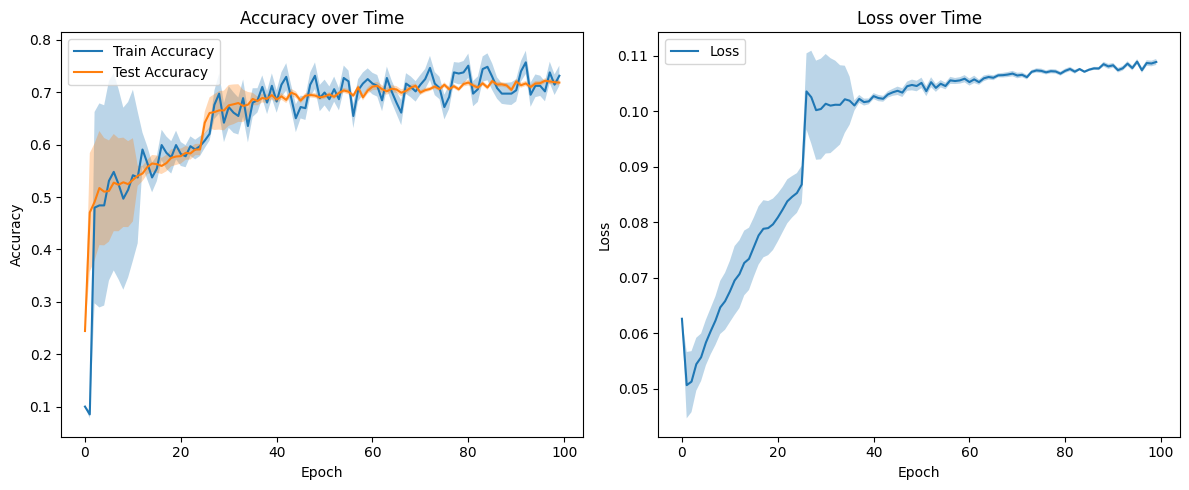

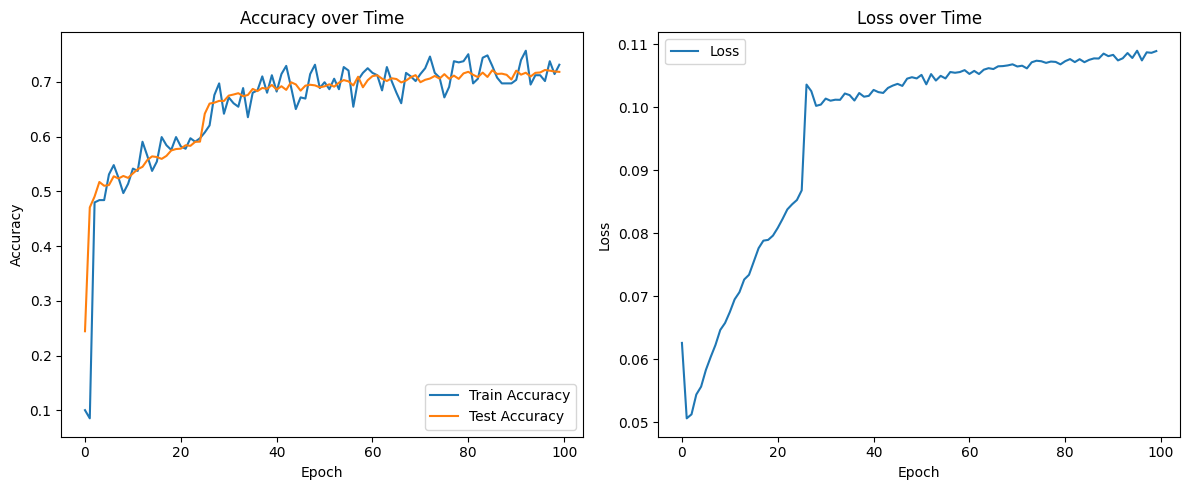

Final Train Accuracy: 0.73 ± 0.02
Final Test Accuracy: 0.72 ± 0.00


In [6]:

config = {
    "batch_size": 128,
    "n_epochs": 100,
    "gamma": 0.99,
    "learning_rate": 1e-3, # 0.0005
    "weight_decay": 1e-4,
    "width": 16,
    "grid": 3,
    "method": "KAN",  # "MLP", "KAN"
    "seed": 0,
    "input_size": 8 * 8, # number of features
    "output_size": 10, # number of classes
    "buffer_size": 100000,
    "target_update": 10,
    "warm_up_episodes": 2,
    "num_filters": 4,
    "num_conv_layers": 2,
    "first_channel": 1, # (1,8,8)
    "hidden_dim": 128,
    "feature_selection": True,
    "distribution": "beta", # bernoulli, categorical, gumbel_softmax, gaussian, beta, dirichlet
    "initial_tau": 1.0, # positive float value

}

q_network, train_accuracies, test_accuracies, losses, probs_history, feedback_cost_history, train_acc_stds, test_acc_stds, loss_stds, agent = kanRL(config)

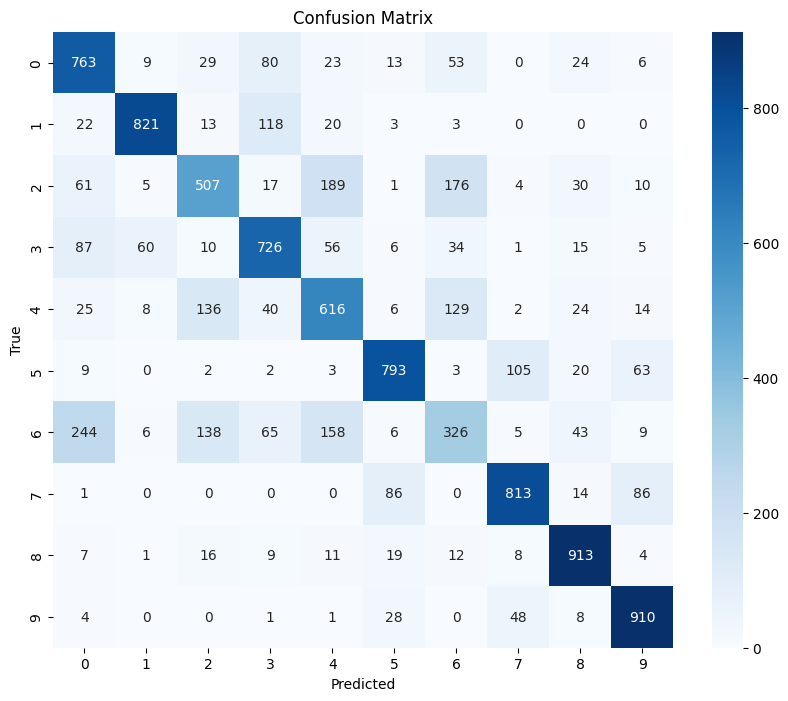

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []  # Ground truth labels
y_pred = []  # Model predictions

# Assuming `test_loader` is your DataLoader for test set
with torch.no_grad():
        # transforms.Normalize((0.1307,), (0.3081,)) # MNIST
        # transforms.Normalize((0.5,), (0.5,)) # FashionMNIST
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # CIFAR10
        # transforms.Normalize((0.50707516, 0.48654887, 0.44091784), (0.26733429, 0.25643846, 0.27615047)), # CIFAR100
    for images, labels in DataLoader(datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
        transforms.Resize((int(config['input_size']**0.5), int(config['input_size']**0.5))),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)), # FashionMNIST
        transforms.Grayscale(num_output_channels=1)
    ])), batch_size=config["batch_size"]):
        state = images.view(-1,config["input_size"])
        if config["feature_selection"] == True:
            flat_zoom_X, _, _ = agent(state)
            state = flat_zoom_X
        outputs = q_network(state)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels)
        y_pred.extend(predicted)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import sklearn
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.76      0.69      1000
           1       0.90      0.82      0.86      1000
           2       0.60      0.51      0.55      1000
           3       0.69      0.73      0.71      1000
           4       0.57      0.62      0.59      1000
           5       0.83      0.79      0.81      1000
           6       0.44      0.33      0.38      1000
           7       0.82      0.81      0.82      1000
           8       0.84      0.91      0.87      1000
           9       0.82      0.91      0.86      1000

    accuracy                           0.72     10000
   macro avg       0.71      0.72      0.71     10000
weighted avg       0.71      0.72      0.71     10000



In [9]:
import gc
gc.collect()

12355